In [241]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

In [242]:
training_data = datasets.MNIST(
    root="data", train=True, download=True, transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data", train=False, download=True, transform=ToTensor()
)

train_dataloader = torch.utils.data.DataLoader(
    training_data, batch_size=10, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle=True)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

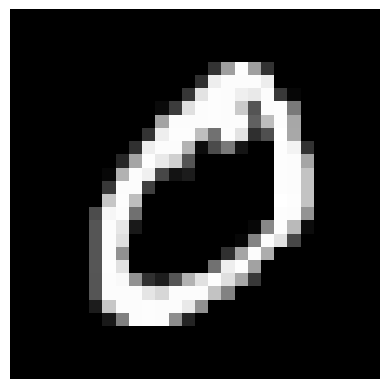

In [243]:
img, label = training_data[1]
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")
print(img)

In [244]:
img.shape

torch.Size([1, 28, 28])

In [245]:
training_data.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [246]:
train_labels = training_data.train_labels

/opt/homebrew/Caskroom/miniforge/base/envs/minst-project/lib/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


Text(0.5, 1.0, 'MINST Dataset Analysis')

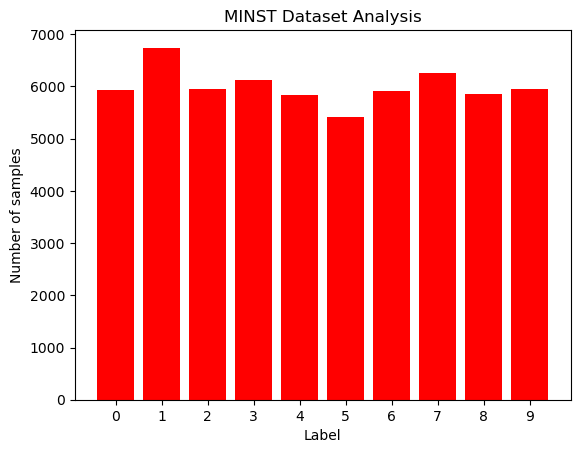

In [247]:
labels_counts = np.unique(train_labels.numpy(), return_counts=True)
x_values = []
for idx, v in enumerate(labels_counts[0]):
    x_values.append(str(v))

print(x_values)
plt.bar(x_values, labels_counts[1], color="red")
plt.xlabel("Label")
plt.ylabel("Number of samples")
plt.title("MINST Dataset Analysis")

In [248]:
print("GPU: {}", torch.cuda.is_available())
print("MPS: {}", torch.backends.mps.is_available())

GPU: {} False
MPS: {} True


In [249]:
device = torch.device("cpu")
device

device(type='cpu')

In [250]:
criterion = nn.CrossEntropyLoss().to(device)

In [251]:
import lightning as L
from lightning.pytorch.utilities.types import STEP_OUTPUT, OptimizerLRScheduler
from torch import nn
import torch.nn.functional as F
import torchmetrics


class LightningNeuralNetwork(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # nn.Dropout(0.2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(16 * 4 * 4, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),
        )

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, batch, batch_idx):
        inputs, labels = batch

        # Make predictions for this batch
        outputs = self.model(inputs)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        self.log("train_loss", loss, on_epoch=True)
        accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
        self.log("train_acc", accuracy(outputs, labels))
        return loss

    def validation_step(self, val_batch, batch_idx):
        inputs, labels = val_batch
        outputs = self.model(inputs)
        loss = criterion(outputs, labels)
        self.log("val_loss", loss)
        accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
        self.log("val_acc", accuracy(outputs, labels))

In [274]:
model = LightningNeuralNetwork()
trainer = L.Trainer(accelerator=device.type, devices=1, max_epochs=11)
trainer.fit(model, train_dataloader, test_dataloader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniforge/base/envs/minst-project/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 44.4 K
-------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)


/opt/homebrew/Caskroom/miniforge/base/envs/minst-project/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/opt/homebrew/Caskroom/miniforge/base/envs/minst-project/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/opt/homebrew/Caskroom/miniforge/base/envs/minst-project/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 10: 100%|██████████| 6000/6000 [00:35<00:00, 170.76it/s, v_num=20]

`Trainer.fit` stopped: `max_epochs=11` reached.


Epoch 10: 100%|██████████| 6000/6000 [00:35<00:00, 170.74it/s, v_num=20]


In [253]:
def make_prediction(x):
    with torch.no_grad():
        prediction = model(x)
        classes = training_data.classes
        return classes[np.argmax(prediction)]

(28, 28, 4)
(1, 28, 28)


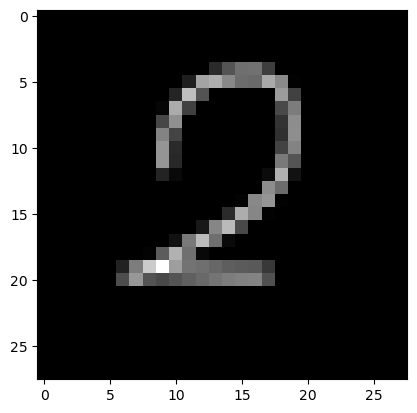

In [285]:
from PIL import Image

my_image = Image.open("./My images/Zrzut ekranu 2023-11-12 o 03.00.06.png")
my_image = my_image.resize((28, 28))
my_image_array = np.array(my_image)
my_image_to_recognize = my_image_array[:, :, 0].reshape(1, 28, 28)
my_image_to_recognize = (my_image_to_recognize - np.min(my_image_to_recognize)) / (
    np.max(my_image_to_recognize) - np.min(my_image_to_recognize)
)
my_image_to_recognize = 1 - my_image_to_recognize
print(my_image_array.shape)
print(my_image_to_recognize.shape)
plt.imshow(my_image_to_recognize.squeeze(), cmap="gray")

In [286]:
model.eval()
image_tensor = torch.from_numpy(my_image_to_recognize).float().unsqueeze(0).to(device)
print(image_tensor.shape)
print(image_tensor)

torch.Size([1, 1, 28, 28])
tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.000

In [287]:
print(make_prediction(image_tensor))

2 - two
